Exploratory Data Analysis
Retriving the data:

In [62]:
import pandas as pd
from sqlalchemy import create_engine

# Replace these variables with your database connection details
db_user = 'UNIVEN_Administrator'
db_password = 'B1b0012'
db_host = '192.168.50.104\\MSSQLSERVER01'  # Double backslash for instance name
db_port = '1433'  # Default SQL Server port is 1433
db_name = 'DatathonDw2024'

# Create the connection string for SQLAlchemy
connection_string = f'mssql+pyodbc://{db_user}:{db_password}@{db_host}/{db_name}?driver=ODBC+Driver+17+for+SQL+Server'

# Create the database engine
engine = create_engine(connection_string)

# Query to fetch data from the joined tables
query = """
SELECT DISTINCT TOP 300000
    cp.[ClaimId],
    cp.[PersonId],
    med.[MedicineId],
    med.[NappiCode],
    diag.[Icd10CodeId],
    icd.[CHAPTER_NO],
    icd.[CHAPTER_DESCRIPTION],
    icd.[GROUP_CODE],
    icd.[GROUP_DESCRIPTION],
    icd.[ICD10_CODE],
    icd.[WHO_FULL_DESC],
    icd.[VALID_ICD10_CLINICALUSE],
    icd.[VALID_ICD10_PRIMARY],
    cd.[ProcessDate],
    cml.[AddressId],
    alr.[Suburb],
    alr.[Town],
    alr.[PostalCode]
FROM [DatathonDw2024].[dbo].[ClaimsPerson] cp
INNER JOIN [DatathonDw2024].[dbo].[Medication] med
    ON cp.[ClaimId] = med.[ClaimId]
INNER JOIN [DatathonDw2024].[dbo].[MedicationDiagnosis] diag
    ON med.[MedicineId] = diag.[MedicineId]
INNER JOIN [DatathonDw2024].[dbo].[Icd10Codes_Ref] icd
    ON diag.[Icd10CodeId] = icd.[Icd10CodeId]
INNER JOIN [DatathonDw2024].[dbo].[ClaimsDate] cd
    ON cp.[ClaimId] = cd.[ClaimId]
INNER JOIN [DatathonDw2024].[dbo].[ClaimsMainMemberLocation] cml
    ON cp.[ClaimId] = cml.[ClaimId]
INNER JOIN [DatathonDw2024].[dbo].[AddressLocation_Ref] alr
    ON cml.[AddressId] = alr.[id]
WHERE (icd.[ICD10_CODE] BETWEEN 'A00' AND 'B99')  -- Certain infectious and parasitic diseases
   OR (icd.[ICD10_CODE] BETWEEN 'U00' AND 'U85')  -- Codes for special purposes
ORDER BY cd.[ProcessDate] DESC;  -- Order by the most recent ProcessDate

"""


try:
    # Read data into a pandas DataFrame
    main = pd.read_sql(query, engine)
    main.shape
    # Display the first 5 rows of the DataFrame
    print(main.head())
except Exception as e:
    print("An error occurred:", e)


     ClaimId  PersonId  MedicineId  NappiCode  Icd10CodeId    CHAPTER_NO  \
0  230022078  10182560   332047386  754757005         1054  CHAPTER XXII   
1  230030526  19801524   252039043  496125004         1037     CHAPTER I   
2  229943125   3901661   276714335  651996001         6507     CHAPTER I   
3  230179150  12757980   319428110  758256028        11956     CHAPTER I   
4  230120935  15309599   413026114  713372001         6762  CHAPTER XXII   

                                 CHAPTER_DESCRIPTION GROUP_CODE  \
0               Codes for special purposes (U00-U99)        262   
1  Certain infectious and parasitic diseases (A00...        004   
2  Certain infectious and parasitic diseases (A00...        017   
3  Certain infectious and parasitic diseases (A00...        016   
4               Codes for special purposes (U00-U99)        262   

                                   GROUP_DESCRIPTION ICD10_CODE  \
0  Provisional assignment of new diseases of unce...        U27   
1     

In [63]:
# Define the SQL query
query = """
WITH DiseaseCounts AS (
    SELECT 
        icd.[ICD10_CODE], 
        COUNT(cp.[ClaimId]) AS Total_Disease_Count,
        COUNT(DISTINCT CAST(cd.[ProcessDate] AS DATE)) AS Total_Days
    FROM [DatathonDw2024].[dbo].[ClaimsPerson] cp
    INNER JOIN [DatathonDw2024].[dbo].[Medication] med
        ON cp.[ClaimId] = med.[ClaimId]
    INNER JOIN [DatathonDw2024].[dbo].[MedicationDiagnosis] diag
        ON med.[MedicineId] = diag.[MedicineId]
    INNER JOIN [DatathonDw2024].[dbo].[Icd10Codes_Ref] icd
        ON diag.[Icd10CodeId] = icd.[Icd10CodeId]
    INNER JOIN [DatathonDw2024].[dbo].[ClaimsDate] cd
        ON cp.[ClaimId] = cd.[ClaimId]
    WHERE (icd.[ICD10_CODE] BETWEEN 'A00' AND 'B99')  -- Infectious/parasitic diseases
       OR (icd.[ICD10_CODE] BETWEEN 'U00' AND 'U85')  -- Codes for special purposes
       AND CAST(cd.[ProcessDate] AS DATE) BETWEEN '2023-05-30' AND '2024-08-16'
    GROUP BY icd.[ICD10_CODE]
),
DiseaseStats AS (
    SELECT 
        [ICD10_CODE],
        SUM(Total_Disease_Count) AS Total_Claims,
        SUM(Total_Disease_Count) * 1.0 / SUM(Total_Days) AS Mean_Count,
        STDEV(SUM(Total_Disease_Count) * 1.0 / SUM(Total_Days)) OVER() AS Std_Dev_Count
    FROM DiseaseCounts
    GROUP BY [ICD10_CODE]
)
SELECT 
    '2023-05-30 - 2024-08-16' AS Period,
    ICD10_CODE,
    Total_Claims AS Total_Disease_Count,
    Mean_Count,
    (Mean_Count + 2 * Std_Dev_Count) AS Threshold
FROM DiseaseStats
ORDER BY ICD10_CODE;
"""

# Execute the query and fetch the results into a DataFrame
diseaseCounts = pd.read_sql(query, engine)

In [64]:
postalDF = pd.read_csv(r"C:\Users\Administrator\Desktop\team Univen\Book1.csv")
print(postalDF)

            SUBURB BOX-CODE STR-CODE            AREA Unnamed: 4
0      AALWYNFLEUR      NaN     6670      RIVERSDALE        NaN
1          AANDRUS      NaN     9301    BLOEMFONTEIN        NaN
2        ABAPHEHLI     4126      NaN        DOONSIDE        NaN
3       ABBOTSDALE      NaN     7300      MALMESBURY        NaN
4       ABBOTSFORD     5210     5241     EAST LONDON        NaN
...            ...      ...      ...             ...        ...
21659        ZWIDE     6204     6201  PORT ELIZABETH        NaN
21660  ZWIDE EXT 3      NaN     6205  PORT ELIZABETH        NaN
21661  ZWIDE UIT 3      NaN     6205  PORT ELIZABETH        NaN
21662  ZWIDE EXT 4      NaN     6205  PORT ELIZABETH        NaN
21663  ZWIDE UIT 4      NaN     6205  PORT ELIZABETH        NaN

[21664 rows x 5 columns]


In [65]:
query = """
WITH DailyDiseaseCounts AS (
    SELECT 
        CAST(cd.[ProcessDate] AS DATE) AS DiseaseDate, -- Using the exact ProcessDate as the date for grouping
        icd.[ICD10_CODE], 
        COUNT(cp.[ClaimId]) AS Daily_Disease_Count
    FROM [DatathonDw2024].[dbo].[ClaimsPerson] cp
    INNER JOIN [DatathonDw2024].[dbo].[Medication] med
        ON cp.[ClaimId] = med.[ClaimId]
    INNER JOIN [DatathonDw2024].[dbo].[MedicationDiagnosis] diag
        ON med.[MedicineId] = diag.[MedicineId]
    INNER JOIN [DatathonDw2024].[dbo].[Icd10Codes_Ref] icd
        ON diag.[Icd10CodeId] = icd.[Icd10CodeId]
    INNER JOIN [DatathonDw2024].[dbo].[ClaimsDate] cd
        ON cp.[ClaimId] = cd.[ClaimId]
    WHERE (icd.[ICD10_CODE] BETWEEN 'A00' AND 'B99')  -- Infectious/parasitic diseases
       OR (icd.[ICD10_CODE] BETWEEN 'U00' AND 'U85')  -- Codes for special purposes
    GROUP BY CAST(cd.[ProcessDate] AS DATE), icd.[ICD10_CODE]
),
DiseaseStats AS (
    SELECT 
        DiseaseDate,
        AVG(Daily_Disease_Count) AS Mean_Count,
        STDEV(Daily_Disease_Count) AS Std_Dev_Count
    FROM DailyDiseaseCounts
    GROUP BY DiseaseDate
),
DiseaseThresholds AS (
    SELECT 
        tdc.DiseaseDate,
        tdc.[ICD10_CODE],
        tdc.[Daily_Disease_Count],
        ds.Mean_Count,
        ds.Std_Dev_Count,
        -- Calculate the threshold dynamically using the mean and 2 standard deviations
        (ds.Mean_Count + 2 * ds.Std_Dev_Count) AS Threshold
    FROM DailyDiseaseCounts tdc
    INNER JOIN DiseaseStats ds
        ON tdc.DiseaseDate = ds.DiseaseDate
)
SELECT 
    DiseaseDate,
    ICD10_CODE,
    Daily_Disease_Count,
    Threshold,
    CASE 
        WHEN Daily_Disease_Count > Threshold THEN 'Anomaly'
        ELSE 'Normal'
    END AS Anomaly_Flag
FROM DiseaseThresholds
ORDER BY DiseaseDate, ICD10_CODE, Daily_Disease_Count DESC;


"""


try:
    # Read data into a pandas DataFrame
    df = pd.read_sql(query, engine)
    df2 = df
    df.shape
    # Display the first 5 rows of the DataFrame
    print(df.head())
except Exception as e:
    print("An error occurred:", e)

  DiseaseDate ICD10_CODE  Daily_Disease_Count  Threshold Anomaly_Flag
0  2023-01-01        A24                    9   39.56049       Normal
1  2023-01-01      A68.9                   82   39.56049      Anomaly
2  2023-01-01      A80.9                    2   39.56049       Normal
3  2023-01-01      A83.5                    2   39.56049       Normal
4  2023-01-01      A83.8                    1   39.56049       Normal


Data Preparation

In [66]:
# Count null values in the relevant columns of df
null_values_df = main[['Suburb', 'Town', 'PostalCode']].isnull().sum()

# Display the result for df
print("Null values in df:")
print(null_values_df)

Null values in df:
Suburb        127934
Town          201059
PostalCode    141147
dtype: int64


Reparing Town

In [67]:
# Step 1: Identify rows in df where Town is null
null_town_rows = main[main['Town'].isnull()]

# Step 2: Use PostalCode to fetch corresponding AREA from postalDF and update Town
for index, row in null_town_rows.iterrows():
    postal_code = row['PostalCode']
    
    # Check if PostalCode is not null
    if pd.notnull(postal_code):
        # Find the corresponding AREA in postalDF using STR-CODE
        area = postalDF.loc[postalDF['STR-CODE'].astype(str) == str(postal_code), 'AREA'].values
        
        # If an AREA was found, update the Town column in df
        if len(area) > 0:  # Ensure the area is not empty
            main.at[index, 'Town'] = area[0]

# Step 3: Check the updated df
df.shape # This should now show fewer rows or none with null Town



(44584, 5)

In [ ]:
# Step 1: Identify rows in df where Town is null
null_town_rows = main[main['Town'].isnull()]

# Step 2: Use Suburb to fetch corresponding AREA from postalDF and update Town
for index, row in null_town_rows.iterrows():
    suburb = row['Suburb']
    
    # Check if Suburb is not null
    if pd.notnull(suburb):
        # Convert both Suburb and SUBURB to lowercase for case-insensitive matching
        area = postalDF.loc[postalDF['SUBURB'].str.lower() == suburb.lower(), 'AREA'].values
        
        # If an AREA was found, update the Town column in df
        if len(area) > 0:  # Ensure the area is not empty
            main.at[index, 'Town'] = area[0]

# Step 3: Check the updated df
main.shape  # This should now show fewer rows or none with null Town

In [ ]:
# Count null values in the relevant columns of df
null_values_df = main[['Suburb', 'Town', 'PostalCode']].isnull().sum()

# Display the result for df
print("Null values in df:")
print(null_values_df)

Null values in df:
Suburb        127929
Town          116565
PostalCode    141146
dtype: int64


In [ ]:
# Assuming `df` is your original dataframe and `diseaseCounts` contains the 'Threshold' column

# Select only the relevant columns ('ICD10_CODE' and 'Threshold') from the diseaseCounts dataframe
diseaseCounts_selected = diseaseCounts[['ICD10_CODE', 'Threshold']]

# Merge `df` with the selected columns from `diseaseCounts` based on 'ICD10_CODE'
merged_df = pd.merge(main, diseaseCounts_selected, on='ICD10_CODE', how='left')

# Remove rows where the 'Threshold' column has null values
merged_df = merged_df.dropna(subset=['Threshold'])

# Display the merged dataframe with only the Threshold column added
print(merged_df)


          ClaimId  PersonId  MedicineId   NappiCode  Icd10CodeId  \
0       230055106   2193785   313985254  3006622001         7606   
1       230101594   2008131   252129030   527096001         5892   
2       230019878   2626625   252017710   683223002         5949   
3       229996585   1586078   313945432   708053001        11953   
4       230145794  14323698   319407609   576425001         5892   
...           ...       ...         ...         ...          ...   
299995  169712209  11262850   256871883   714957001         1040   
299996  169679572  10488461   166607489   490256006         5948   
299997  169780895  10939349   178539674   715703001         1040   
299998  169783322  15513580   257030095   716050001         1428   
299999  169677748  15194307   178388730   711993009         6507   

          CHAPTER_NO                                CHAPTER_DESCRIPTION  \
0          CHAPTER I  Certain infectious and parasitic diseases (A00...   
1          CHAPTER I  Certain inf

In [ ]:
diseaseCounts

,Period,ICD10_CODE,Total_Disease_Count,Mean_Count,Threshold
0,2023-05-30 - 2024-08-16,A01.4,170,8.947368,39.902595
1,2023-05-30 - 2024-08-16,A16.9,171,24.428571,55.383798
2,2023-05-30 - 2024-08-16,A17,187,4.452381,35.407608
3,2023-05-30 - 2024-08-16,A17.0,307,3.301075,34.256302
4,2023-05-30 - 2024-08-16,A17.1,50,2.000000,32.955227
...,...,...,...,...,...
448,2023-05-30 - 2024-08-16,U48.6,3384,10.811502,41.766728
449,2023-05-30 - 2024-08-16,U49.3,2029,11.087432,42.042658
450,2023-05-30 - 2024-08-16,U49.5,2,1.000000,31.955227
451,2023-05-30 - 2024-08-16,U49.7,58,7.250000,38.205227


Data Visualization on Daily Disease count vs Threshhold

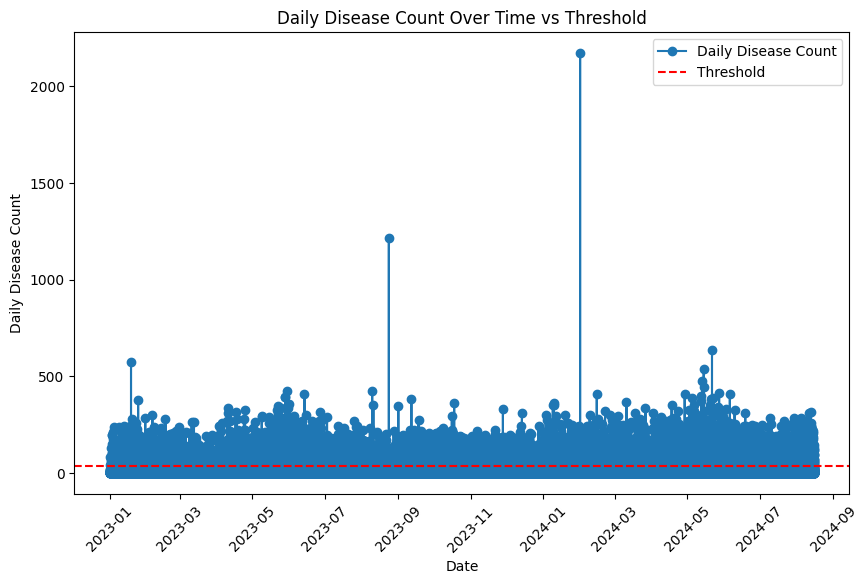

In [ ]:
import matplotlib.pyplot as plt

# Ensure 'DiseaseDate' is in datetime format if not already
df['DiseaseDate'] = pd.to_datetime(df['DiseaseDate'])

# Line plot for Daily Disease Count over time with Threshold line
plt.figure(figsize=(10,6))

# Plot Daily Disease Count
plt.plot(df['DiseaseDate'], df['Daily_Disease_Count'], marker='o', label='Daily Disease Count')

# Plot Threshold as a constant line
plt.axhline(y=df['Threshold'].iloc[0], color='r', linestyle='--', label='Threshold')

# Adding title and labels
plt.title('Daily Disease Count Over Time vs Threshold')
plt.xlabel('Date')
plt.ylabel('Daily Disease Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show legend
plt.legend()

# Display plot
plt.show()

In [ ]:
# Descriptive statistics for the numerical columns 'Daily_Disease_Count' and 'Threshold'
print(df[['Daily_Disease_Count', 'Threshold']].describe())

# Count anomalies vs normal by displaying the count of each category in 'Anomaly_Flag'
print(df['Anomaly_Flag'].value_counts())

       Daily_Disease_Count     Threshold
count         44584.000000  44584.000000
mean             20.099856     95.169826
std              41.113260     36.694080
min               1.000000     18.661435
25%               2.000000     79.750435
50%               5.000000     97.568803
75%              17.000000    112.731731
max            2170.000000    487.508391
Anomaly_Flag
Normal     41847
Anomaly     2737
Name: count, dtype: int64


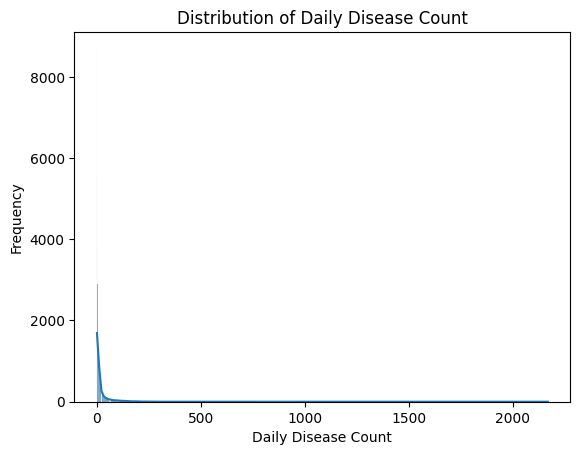

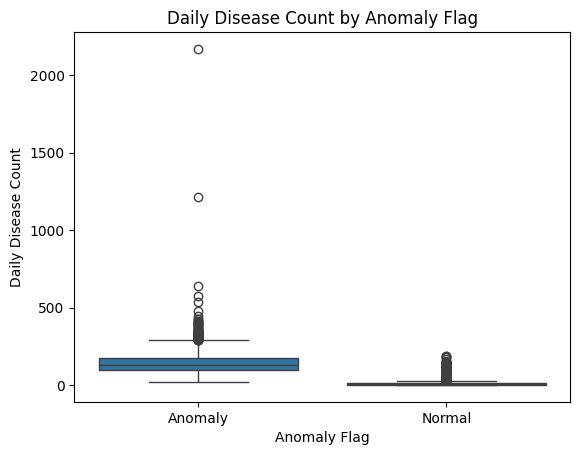

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure no NaN values are present in relevant columns
df = df.dropna(subset=['Daily_Disease_Count', 'Anomaly_Flag'])

# Ensure 'Anomaly_Flag' is categorical for boxplot
df['Anomaly_Flag'] = df['Anomaly_Flag'].astype('category')

# Histogram of Daily Disease Count with KDE (Kernel Density Estimate)
sns.histplot(df['Daily_Disease_Count'], kde=True)
plt.title('Distribution of Daily Disease Count')
plt.xlabel('Daily Disease Count')
plt.ylabel('Frequency')
plt.show()

# Boxplot of Daily Disease Count by Anomaly Flag
sns.boxplot(x='Anomaly_Flag', y='Daily_Disease_Count', data=df)
plt.title('Daily Disease Count by Anomaly Flag')
plt.xlabel('Anomaly Flag')
plt.ylabel('Daily Disease Count')
plt.show()


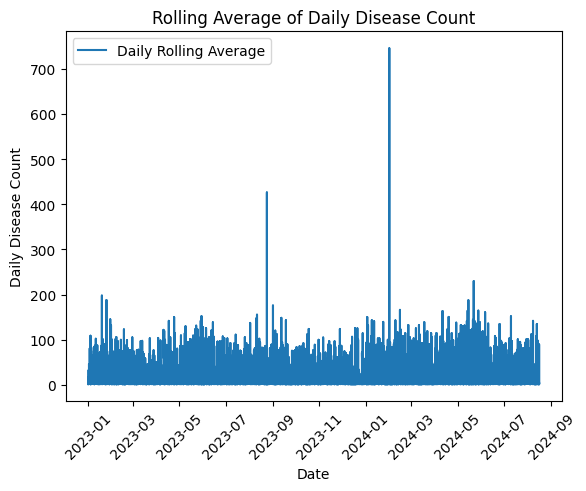

In [ ]:
# Calculate rolling average of Daily Disease Count (3 weeks window)
df['Rolling_Avg'] = df['Daily_Disease_Count'].rolling(window=3).mean()

# Plot the rolling average
plt.plot(df['DiseaseDate'], df['Rolling_Avg'], label='Daily Rolling Average')
plt.xlabel('Date')
plt.ylabel('Daily Disease Count')
plt.title('Rolling Average of Daily Disease Count')
plt.xticks(rotation=45)
plt.legend()
plt.show()


SELECTING TWO TOWNS TO MODEL

In [ ]:
# Step 1: Group by 'Town' and count the number of claims to find the top 2 towns with the highest number of claims
town_claims = merged_df.groupby('Town')['ClaimId'].count().reset_index()
top_2_towns = town_claims.nlargest(2, 'ClaimId')['Town']

# Get the towns with the highest and second-highest claims
highest_claims_town = top_2_towns.iloc[0]
second_highest_claims_town = top_2_towns.iloc[1]

# Step 2: Filter the merged_df for these towns
highest_town_df = merged_df[merged_df['Town'] == highest_claims_town]
second_highest_town_df = merged_df[merged_df['Town'] == second_highest_claims_town]

# Print the resulting DataFrames
print("Data for the highest claims town:")
print(highest_town_df.head())  # Display the first few rows of the highest claims town

print("\nData for the second-highest claims town:")
print(second_highest_town_df.head())  # Display the first few rows of the second-highest claims town

Data for the highest claims town:
       ClaimId  PersonId  MedicineId   NappiCode  Icd10CodeId    CHAPTER_NO  \
74   229960455  10927551   412981820   717052001         6166  CHAPTER XXII   
85   230008898  15737413   412995575   498262006        11953     CHAPTER I   
118  230088549  19686967   413017987  1022340002           16     CHAPTER I   
132  230023147  19210399   276793797   731234006         6507     CHAPTER I   
152  230008898  15737413   252009991   707365001        11953     CHAPTER I   

                                   CHAPTER_DESCRIPTION GROUP_CODE  \
74                Codes for special purposes (U00-U99)        262   
85   Certain infectious and parasitic diseases (A00...        016   
118  Certain infectious and parasitic diseases (A00...        003   
132  Certain infectious and parasitic diseases (A00...        017   
152  Certain infectious and parasitic diseases (A00...        016   

                                     GROUP_DESCRIPTION ICD10_CODE  \
74   Pr

In [ ]:
# Step 1: Group by 'Town' and count the number of claims to find the top 2 towns with the highest number of claims
town_claims = merged_df.groupby('Town')['ClaimId'].count().reset_index()
top_2_towns = town_claims.nlargest(2, 'ClaimId')['Town']

# Get the towns with the highest and second-highest claims
highest_claims_town = top_2_towns.iloc[0]
second_highest_claims_town = top_2_towns.iloc[1]

# Step 2: Filter the merged_df for these towns
highest_town_df = merged_df[merged_df['Town'] == highest_claims_town]
second_highest_town_df = merged_df[merged_df['Town'] == second_highest_claims_town]

# Step 3: Group by 'ICD10_CODE' and calculate the total number of claims per ICD10 code for each town
highest_town_icd_counts = highest_town_df.groupby('ICD10_CODE')['ClaimId'].count().reset_index()
highest_town_icd_counts.rename(columns={'ClaimId': 'Total_Claims_Per_ICD10'}, inplace=True)

second_highest_town_icd_counts = second_highest_town_df.groupby('ICD10_CODE')['ClaimId'].count().reset_index()
second_highest_town_icd_counts.rename(columns={'ClaimId': 'Total_Claims_Per_ICD10'}, inplace=True)

# Step 4: Merge the total claims per ICD10 code back into the original DataFrames
highest_town_df = pd.merge(highest_town_df, highest_town_icd_counts, on='ICD10_CODE', how='left')
second_highest_town_df = pd.merge(second_highest_town_df, second_highest_town_icd_counts, on='ICD10_CODE', how='left')

# Print the resulting DataFrames with the new column
print("Data for the highest claims town with total claims per ICD10 code:")
print(highest_town_df.head())  # Display the first few rows of the highest claims town

print("\nData for the second-highest claims town with total claims per ICD10 code:")
print(second_highest_town_df.head())  # Display the first few rows of the second-highest claims town

Data for the highest claims town with total claims per ICD10 code:
     ClaimId  PersonId  MedicineId   NappiCode  Icd10CodeId    CHAPTER_NO  \
0  229960455  10927551   412981820   717052001         6166  CHAPTER XXII   
1  230008898  15737413   412995575   498262006        11953     CHAPTER I   
2  230088549  19686967   413017987  1022340002           16     CHAPTER I   
3  230023147  19210399   276793797   731234006         6507     CHAPTER I   
4  230008898  15737413   252009991   707365001        11953     CHAPTER I   

                                 CHAPTER_DESCRIPTION GROUP_CODE  \
0               Codes for special purposes (U00-U99)        262   
1  Certain infectious and parasitic diseases (A00...        016   
2  Certain infectious and parasitic diseases (A00...        003   
3  Certain infectious and parasitic diseases (A00...        017   
4  Certain infectious and parasitic diseases (A00...        016   

                                   GROUP_DESCRIPTION ICD10_CODE  \


In [ ]:
highest_town_df


,ClaimId,PersonId,MedicineId,NappiCode,Icd10CodeId,CHAPTER_NO,CHAPTER_DESCRIPTION,GROUP_CODE,GROUP_DESCRIPTION,ICD10_CODE,WHO_FULL_DESC,VALID_ICD10_CLINICALUSE,VALID_ICD10_PRIMARY,ProcessDate,AddressId,Suburb,Town,PostalCode,Threshold,Total_Claims_Per_ICD10
0,229960455,10927551,412981820,717052001,6166,CHAPTER XXII,Codes for special purposes (U00-U99),262,Provisional assignment of new diseases of unce...,U40.0,Emergency use of U40.0,Y,Y,2024-08-16,3635,PARKTOWN NORTH,JOHANNESBURG,2193,151.472468,489
1,230008898,15737413,412995575,498262006,11953,CHAPTER I,Certain infectious and parasitic diseases (A00...,016,Protozoal diseases,B52.0,Plasmodium malariae malaria with nephropathy,Y,Y,2024-08-16,3698,KIBLER PARK,JOHANNESBURG,2091,42.903441,129
2,230088549,19686967,413017987,1022340002,16,CHAPTER I,Certain infectious and parasitic diseases (A00...,003,Certain zoonotic bacterial diseases,A24,Glanders and melioidosis,N,N,2024-08-16,10720,MONTGOMERY PARK,JOHANNESBURG,2195,75.635970,228
3,230023147,19210399,276793797,731234006,6507,CHAPTER I,Certain infectious and parasitic diseases (A00...,017,Helminthiases,B74.4,Mansonelliasis,Y,Y,2024-08-16,262180,EASTCLIFF,JOHANNESBURG,2190,131.516986,744
4,230008898,15737413,252009991,707365001,11953,CHAPTER I,Certain infectious and parasitic diseases (A00...,016,Protozoal diseases,B52.0,Plasmodium malariae malaria with nephropathy,Y,Y,2024-08-16,3698,KIBLER PARK,JOHANNESBURG,2091,42.903441,129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10617,169852003,10390381,396237780,735930007,4497,CHAPTER XXII,Codes for special purposes (U00-U99),262,Provisional assignment of new diseases of unce...,U47.5,Emergency use of U47.5,Y,Y,2023-12-21,12774,LINDEN,JOHANNESBURG,None,126.047361,484
10618,169852108,10390381,238174491,735930007,4497,CHAPTER XXII,Codes for special purposes (U00-U99),262,Provisional assignment of new diseases of unce...,U47.5,Emergency use of U47.5,Y,Y,2023-12-21,12774,LINDEN,JOHANNESBURG,None,126.047361,484
10619,169857799,15774403,166861069,795623003,6507,CHAPTER I,Certain infectious and parasitic diseases (A00...,017,Helminthiases,B74.4,Mansonelliasis,Y,Y,2023-12-21,7037,BROMHOF,JOHANNESBURG,2154,131.516986,744
10620,169849863,11196873,357291169,718711001,11956,CHAPTER I,Certain infectious and parasitic diseases (A00...,016,Protozoal diseases,B53,Other parasitologically confirmed malaria,N,N,2023-12-21,247662,RIDGEWAY EXT 4,JOHANNESBURG,2091,123.610279,676


C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_7624\4117941330.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_johannesburg_claims, x='ClaimId', y='ICD10_CODE', palette='viridis')


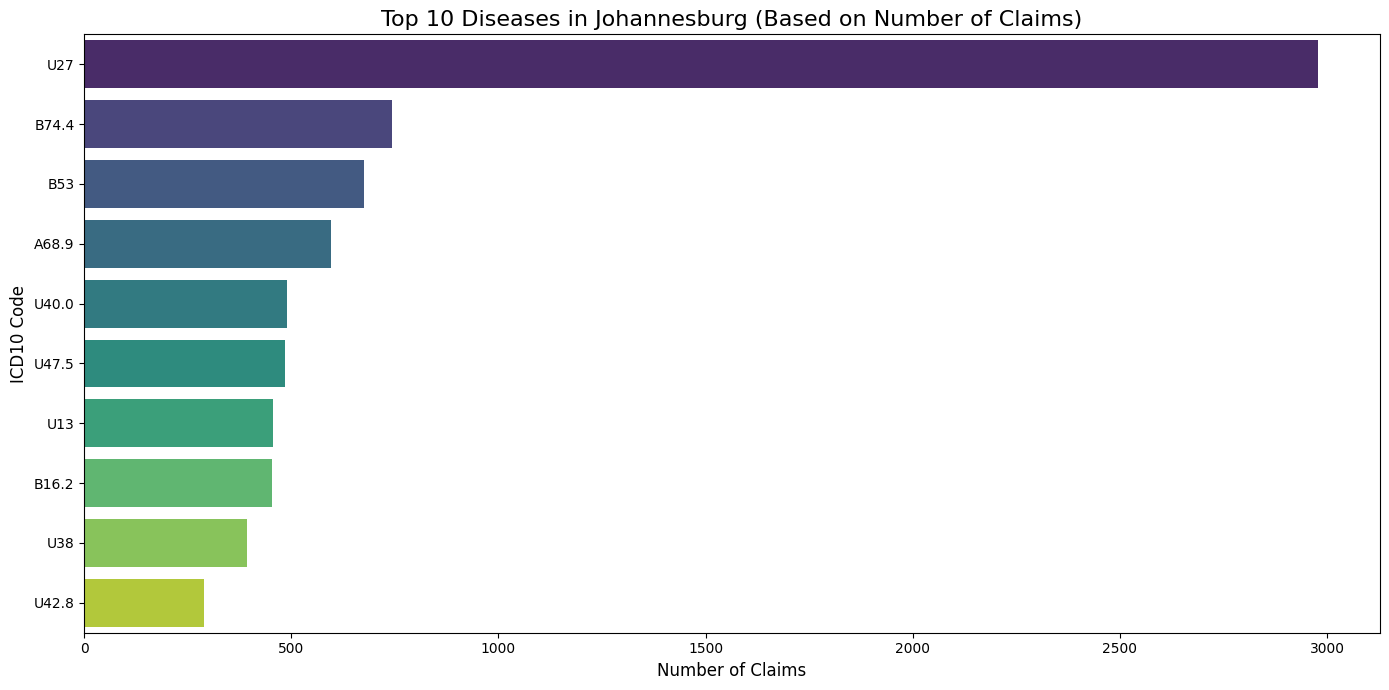

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_7624\4117941330.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_pretoria_claims, x='ClaimId', y='ICD10_CODE', palette='plasma')


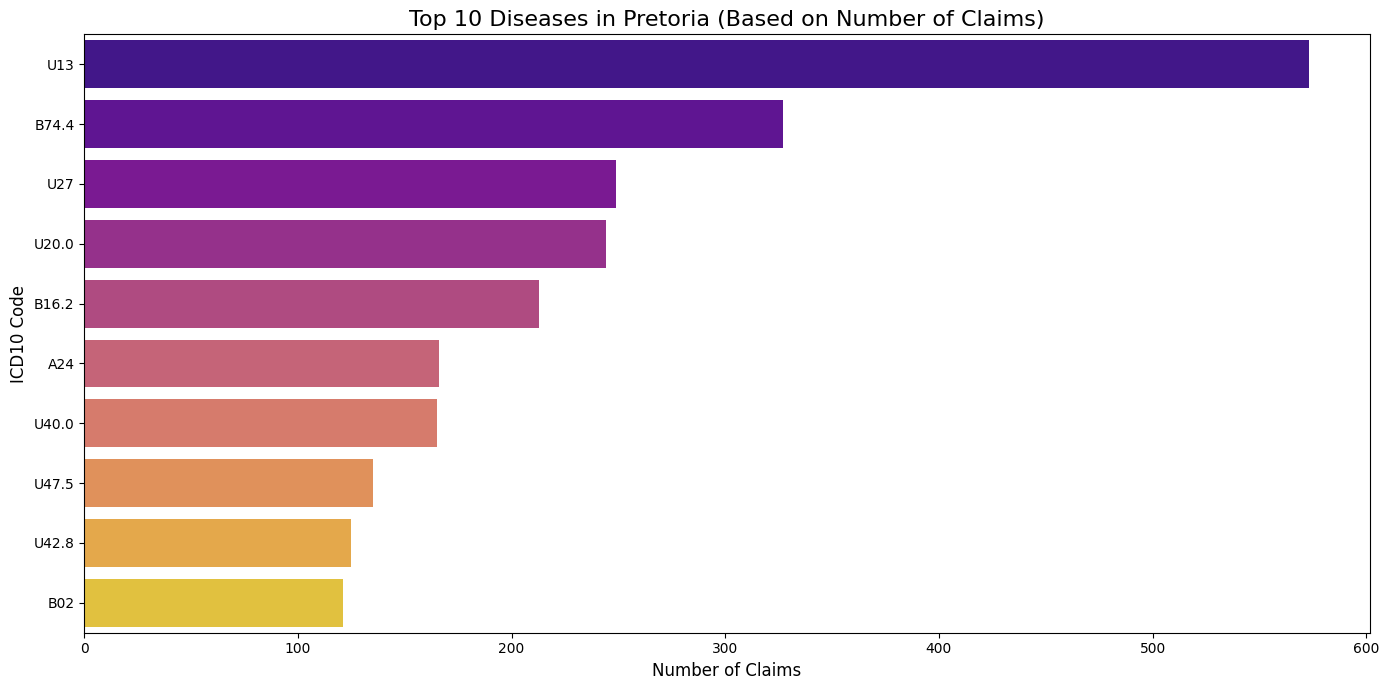

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Group by 'Town' and 'ICD10_CODE' and count the number of claims
town_claim_counts = main.groupby(['Town', 'ICD10_CODE'])['ClaimId'].count().reset_index()

# Step 2: Filter the data for Johannesburg and Pretoria
johannesburg_claim_counts = town_claim_counts[town_claim_counts['Town'] == 'JOHANNESBURG']
pretoria_claim_counts = town_claim_counts[town_claim_counts['Town'] == 'PRETORIA']

# Step 3: Sort by the number of claims in descending order and get the top 10 diseases
top_10_johannesburg_claims = johannesburg_claim_counts.sort_values(by='ClaimId', ascending=False).head(10)
top_10_pretoria_claims = pretoria_claim_counts.sort_values(by='ClaimId', ascending=False).head(10)

# Step 4: Plot the number of claims for the top 10 diseases in Johannesburg
plt.figure(figsize=(14, 7))
sns.barplot(data=top_10_johannesburg_claims, x='ClaimId', y='ICD10_CODE', palette='viridis')
plt.title('Top 10 Diseases in Johannesburg (Based on Number of Claims)', fontsize=16)
plt.xlabel('Number of Claims', fontsize=12)
plt.ylabel('ICD10 Code', fontsize=12)
plt.tight_layout()
plt.show()

# Step 5: Plot the number of claims for the top 10 diseases in Pretoria
plt.figure(figsize=(14, 7))
sns.barplot(data=top_10_pretoria_claims, x='ClaimId', y='ICD10_CODE', palette='plasma')
plt.title('Top 10 Diseases in Pretoria (Based on Number of Claims)', fontsize=16)
plt.xlabel('Number of Claims', fontsize=12)
plt.ylabel('ICD10 Code', fontsize=12)
plt.tight_layout()

In [ ]:
# Step 1: Filter the merged_df for the highest and second-highest claims towns
highest_claims_df = merged_df[merged_df['Town'] == highest_claims_town]
second_highest_claims_df = merged_df[merged_df['Town'] == second_highest_claims_town]

# Step 2: Add the 'Potential_Outbreak' column for both DataFrames
highest_claims_df['Potential_Outbreak'] = highest_claims_df.apply(
    lambda row: 'Yes' if row['ClaimId'] > row['Threshold'] else 'No', axis=1
)

second_highest_claims_df['Potential_Outbreak'] = second_highest_claims_df.apply(
    lambda row: 'Yes' if row['ClaimId'] > row['Threshold'] else 'No', axis=1
)

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_7624\4183501101.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highest_claims_df['Potential_Outbreak'] = highest_claims_df.apply(
C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_7624\4183501101.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_highest_claims_df['Potential_Outbreak'] = second_highest_claims_df.apply(


In [ ]:
highest_claims_df

,ClaimId,PersonId,MedicineId,NappiCode,Icd10CodeId,CHAPTER_NO,CHAPTER_DESCRIPTION,GROUP_CODE,GROUP_DESCRIPTION,ICD10_CODE,WHO_FULL_DESC,VALID_ICD10_CLINICALUSE,VALID_ICD10_PRIMARY,ProcessDate,AddressId,Suburb,Town,PostalCode,Threshold,Potential_Outbreak
74,229960455,10927551,412981820,717052001,6166,CHAPTER XXII,Codes for special purposes (U00-U99),262,Provisional assignment of new diseases of unce...,U40.0,Emergency use of U40.0,Y,Y,2024-08-16,3635,PARKTOWN NORTH,JOHANNESBURG,2193,151.472468,Yes
85,230008898,15737413,412995575,498262006,11953,CHAPTER I,Certain infectious and parasitic diseases (A00...,016,Protozoal diseases,B52.0,Plasmodium malariae malaria with nephropathy,Y,Y,2024-08-16,3698,KIBLER PARK,JOHANNESBURG,2091,42.903441,Yes
118,230088549,19686967,413017987,1022340002,16,CHAPTER I,Certain infectious and parasitic diseases (A00...,003,Certain zoonotic bacterial diseases,A24,Glanders and melioidosis,N,N,2024-08-16,10720,MONTGOMERY PARK,JOHANNESBURG,2195,75.635970,Yes
132,230023147,19210399,276793797,731234006,6507,CHAPTER I,Certain infectious and parasitic diseases (A00...,017,Helminthiases,B74.4,Mansonelliasis,Y,Y,2024-08-16,262180,EASTCLIFF,JOHANNESBURG,2190,131.516986,Yes
152,230008898,15737413,252009991,707365001,11953,CHAPTER I,Certain infectious and parasitic diseases (A00...,016,Protozoal diseases,B52.0,Plasmodium malariae malaria with nephropathy,Y,Y,2024-08-16,3698,KIBLER PARK,JOHANNESBURG,2091,42.903441,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299882,169852003,10390381,396237780,735930007,4497,CHAPTER XXII,Codes for special purposes (U00-U99),262,Provisional assignment of new diseases of unce...,U47.5,Emergency use of U47.5,Y,Y,2023-12-21,12774,LINDEN,JOHANNESBURG,None,126.047361,Yes
299891,169852108,10390381,238174491,735930007,4497,CHAPTER XXII,Codes for special purposes (U00-U99),262,Provisional assignment of new diseases of unce...,U47.5,Emergency use of U47.5,Y,Y,2023-12-21,12774,LINDEN,JOHANNESBURG,None,126.047361,Yes
299899,169857799,15774403,166861069,795623003,6507,CHAPTER I,Certain infectious and parasitic diseases (A00...,017,Helminthiases,B74.4,Mansonelliasis,Y,Y,2023-12-21,7037,BROMHOF,JOHANNESBURG,2154,131.516986,Yes
299903,169849863,11196873,357291169,718711001,11956,CHAPTER I,Certain infectious and parasitic diseases (A00...,016,Protozoal diseases,B53,Other parasitologically confirmed malaria,N,N,2023-12-21,247662,RIDGEWAY EXT 4,JOHANNESBURG,2091,123.610279,Yes


In [ ]:
# Print all the columns of the DataFrame for the highest claims town
print("Columns for the highest claims town:")
print(highest_claims_df.columns)

Columns for the highest claims town:
Index(['ClaimId', 'PersonId', 'MedicineId', 'NappiCode', 'Icd10CodeId',
       'CHAPTER_NO', 'CHAPTER_DESCRIPTION', 'GROUP_CODE', 'GROUP_DESCRIPTION',
       'ICD10_CODE', 'WHO_FULL_DESC', 'VALID_ICD10_CLINICALUSE',
       'VALID_ICD10_PRIMARY', 'ProcessDate', 'AddressId', 'Suburb', 'Town',
       'PostalCode', 'Threshold', 'Potential_Outbreak'],
      dtype='object')


In [ ]:
# Check if any column has NULL (NaN) values
null_columns = highest_claims_df.isnull().sum()

# Display columns that have null values and the count of missing values
print(null_columns[null_columns > 0])

Suburb         212
PostalCode    2467
dtype: int64


In [ ]:
columns_to_remove = ['NappiCode', 'PostalCode', 'Suburb']
df_cleaned = highest_claims_df.drop(columns=columns_to_remove)

In [ ]:
# Check if any column has NULL (NaN) values
null_columns = df_cleaned.isnull().sum()

# Display columns that have null values and the count of missing values
print(null_columns[null_columns > 0])

Series([], dtype: int64)


In [ ]:
# Display columns and their data types
print(df_cleaned.dtypes)

ClaimId                      int64
PersonId                     int64
MedicineId                   int64
Icd10CodeId                  int64
CHAPTER_NO                  object
CHAPTER_DESCRIPTION         object
GROUP_CODE                  object
GROUP_DESCRIPTION           object
ICD10_CODE                  object
WHO_FULL_DESC               object
VALID_ICD10_CLINICALUSE     object
VALID_ICD10_PRIMARY         object
ProcessDate                 object
AddressId                    int64
Town                        object
Threshold                  float64
Potential_Outbreak          object
dtype: object


C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_7624\3296552309.py:27: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df2_filtered['DiseaseDate'] = pd.to_datetime(df2_filtered['DiseaseDate']).view(int) / 10**9  # Corrected to .view(int)


Predicted Threshold values for ICD10_CODE A24: [ 88.9833932  101.19261449 111.00761981 103.24003551  57.72731695
 104.79310327  97.66150304  98.71401808 104.25988181  50.82791946
 100.78193943  93.19376079  58.05191042 110.07550803 101.66348398
 101.44576536 101.90364321  98.66335654  76.32490502 119.87309825
  82.07468976  81.4109995   90.62930323 127.11800159 128.18201835
 118.69665944 107.87279339  51.5107884   89.55171564 103.01051282
 109.28737653 122.84909789  53.316292    59.585139    67.82181711
  97.49882731 103.67069442 110.55847618  52.58852509  68.5049739
 104.63233457 121.45899926  58.39467626  74.1369866   84.21115466
  65.58001069  87.60598942  77.68228421 104.92315495  78.08369185
  96.1709743   83.97171016  48.83261293 107.13887544  88.34915677
  95.25895877  82.05288504 101.45035207  78.24752278  80.92937587
  68.08255401  89.09088786  91.93452145 105.54369319  65.56576309
  44.14036349 116.42734039 114.89683867  85.19562729 114.66389037
  92.33837341 126.95716315 103

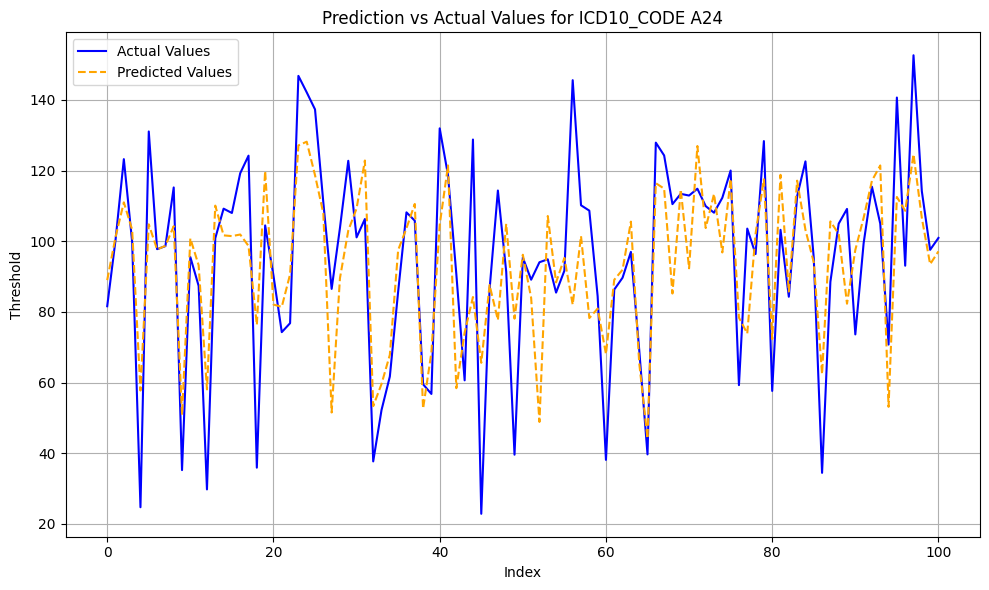

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Filter the dataset for ICD10_CODE == 'A24'
df2_filtered = df2[df2['ICD10_CODE'] == 'A68.9']

# Remove outliers using the IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply outlier removal to relevant numeric columns
numeric_columns = ['DiseaseDate', 'Daily_Disease_Count', 'Threshold']
for col in numeric_columns:
    df2_filtered = remove_outliers(df2_filtered, col)

# Convert DiseaseDate to datetime and then to timestamp (numeric form)
df2_filtered['DiseaseDate'] = pd.to_datetime(df2_filtered['DiseaseDate']).view(int) / 10**9  # Corrected to .view(int)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the 'ICD10_CODE' and 'Anomaly_Flag' columns
df2_filtered['ICD10_CODE_encoded'] = label_encoder.fit_transform(df2_filtered['ICD10_CODE'])
df2_filtered['Anomaly_Flag_encoded'] = label_encoder.fit_transform(df2_filtered['Anomaly_Flag'])

# Features (X) and target (y)
features = ['DiseaseDate', 'ICD10_CODE_encoded', 'Anomaly_Flag_encoded', 'Daily_Disease_Count']
X = df2_filtered[features]
y = df2_filtered['Threshold']

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=50, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict the target for the test set
y_pred = rf_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display the results
print("Predicted Threshold values for ICD10_CODE A24:", y_pred)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

# Ensure y_test is reset as a pandas Series or NumPy array for plotting
y_test = y_test.reset_index(drop=True)

# Plot the Prediction vs Actual values
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', linestyle='-', color='blue')
plt.plot(range(len(y_pred)), y_pred, label='Predicted Values', linestyle='--', color='orange')

# Adding labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Threshold')
plt.title('Prediction vs Actual Values for ICD10_CODE A24')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assuming 'df' is your DataFrame
label_encoder = LabelEncoder()

# List of categorical columns to encode
categorical_columns = [
    'CHAPTER_NO', 'CHAPTER_DESCRIPTION', 'GROUP_CODE', 'GROUP_DESCRIPTION', 
    'ICD10_CODE', 'WHO_FULL_DESC', 'VALID_ICD10_CLINICALUSE', 
    'VALID_ICD10_PRIMARY', 'ProcessDate', 'Town','Threshold', 'Potential_Outbreak'
]

# Apply LabelEncoder to each categorical column
for column in categorical_columns:
    df_cleaned[column] = label_encoder.fit_transform(df_cleaned[column].astype(str))

# Display the encoded DataFrame
print(df_cleaned.head())


       ClaimId  PersonId  MedicineId  Icd10CodeId  CHAPTER_NO  \
74   229960455  10927551   412981820         6166           1   
85   230008898  15737413   412995575        11953           0   
118  230088549  19686967   413017987           16           0   
132  230023147  19210399   276793797         6507           0   
152  230008898  15737413   252009991        11953           0   

     CHAPTER_DESCRIPTION  GROUP_CODE  GROUP_DESCRIPTION  ICD10_CODE  \
74                     1          14                  9         106   
85                     0          11                  8          57   
118                    0           1                  1           2   
132                    0          12                  2          69   
152                    0          11                  8          57   

     WHO_FULL_DESC  VALID_ICD10_CLINICALUSE  VALID_ICD10_PRIMARY  ProcessDate  \
74              52                        1                    1          239   
85              92  

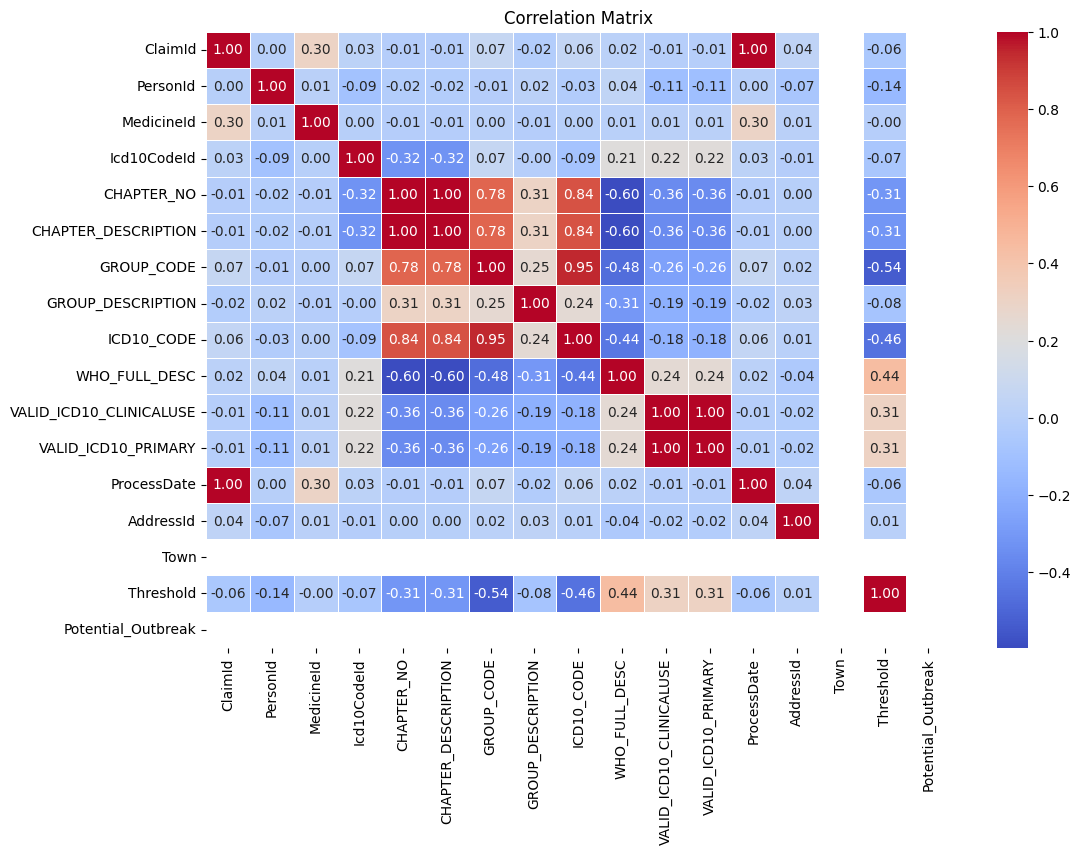

In [ ]:
# Select numeric columns only for correlation calculation
numeric_columns = df_cleaned.select_dtypes(include=['number']).columns

# Calculate the correlation matrix using only numeric columns
correlation_matrix = df_cleaned[numeric_columns].corr()

# Plot the heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


# Inspect data structure
print(dadf_cleaned.head())

# Select features and target variable
# Replace 'target_column' with your target variable column name
target_column = 'VALID_ICD10_CLINICALUSE'
features = ['ClaimId', 'PersonId', 'MedicineId', 'Icd10CodeId']  # Adjust as necessary
X = df_cleaned[features]
y = df_cleaned[target_column]

# Handle missing values
X.fillna(0, inplace=True)

# Encode categorical variables if needed (Label Encoding or One-Hot Encoding)
X = pd.get_dummies(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Predict on new data
new_data = X_test.iloc[:5]  # Example of prediction on the test set
predictions = rf_model.predict(new_data)
print("Predictions:", predictions)


NameError: name 'dadf_cleaned' is not defined

ADF Statistic: -3.3238574712709203
p-value: 0.013845148335276126
The series is stationary.


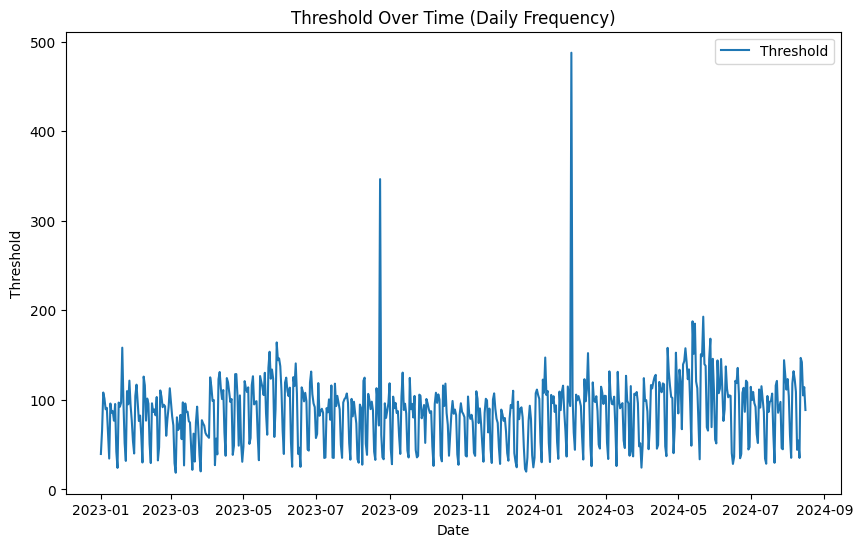

Forecasted Thresholds for the Next 10 Days:
2024-08-17     68.553572
2024-08-18    107.425262
2024-08-19    122.358020
2024-08-20    107.503626
2024-08-21    107.639205
2024-08-22    101.922652
2024-08-23     89.103383
2024-08-24     99.048511
2024-08-25    110.198717
2024-08-26    106.669464
Freq: D, Name: predicted_mean, dtype: float64


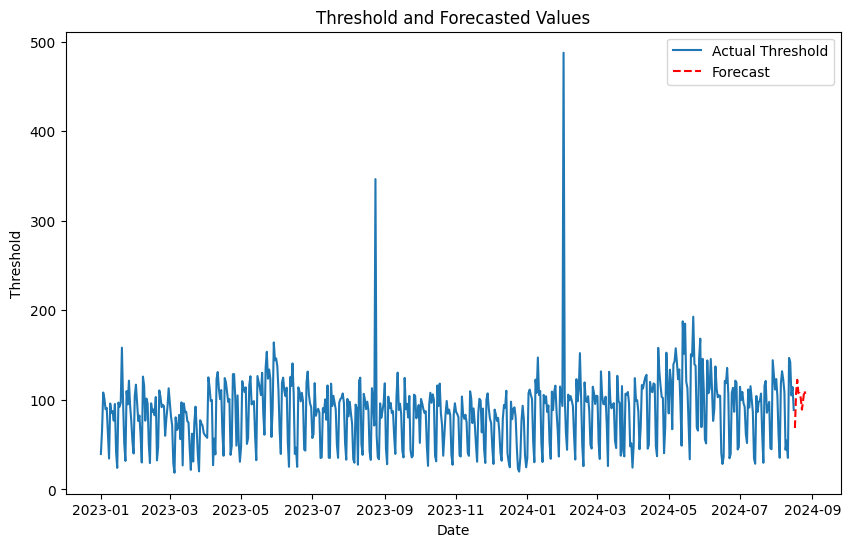


Evaluation Metrics:
Mean Absolute Error (MAE): 30.866699268143957
Root Mean Squared Error (RMSE): 39.23166960749158
Mean Absolute Percentage Error (MAPE): 49.771473988250584%

Predicted Threshold for 2024-12-10 00:00:00: 68.55357232120694


C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_7624\1333630636.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"\nPredicted Threshold for {specific_forecast_date}: {forecast[0]}")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

try:
    # Ensure the 'Date' column is in datetime format and set it as the index
    df['DiseaseDate'] = pd.to_datetime(df['DiseaseDate'])
    df.set_index('DiseaseDate', inplace=True)

    # Resample the data to a desired frequency (e.g., daily, weekly)
    # Using daily data here, but you can adjust to '3D' for 3-day or 'W' for weekly aggregation
    df_resampled = df['Threshold'].resample('D').mean()

    # Check for stationarity using the Augmented Dickey-Fuller Test (ADF)
    result = adfuller(df_resampled.dropna())  # Drop NA values for the test
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    # If the p-value is less than 0.05, the series is stationary
    if result[1] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary. Differencing might be needed.")

    # Visualizing the resampled data
    plt.figure(figsize=(10, 6))
    plt.plot(df_resampled, label='Threshold')
    plt.title('Threshold Over Time (Daily Frequency)')
    plt.xlabel('Date')
    plt.ylabel('Threshold')
    plt.legend()
    plt.show()

    # Train an ARIMA model on the resampled data
    # You can experiment with different (p, d, q) parameters; (5, 1, 0) is just an example
    model = ARIMA(df_resampled, order=(5, 1, 0))
    model_fit = model.fit()

    # Forecast the next 10 periods (change forecast_steps as needed)
    forecast_steps = 10
    forecast = model_fit.forecast(steps=forecast_steps)

    # Print forecasted values
    print("Forecasted Thresholds for the Next 10 Days:")
    print(forecast)

    # Visualize the forecasted values
    plt.figure(figsize=(10, 6))
    plt.plot(df_resampled, label='Actual Threshold')
    plt.plot(pd.date_range(df_resampled.index[-1], periods=forecast_steps + 1, freq='D')[1:], forecast, label='Forecast', color='red', linestyle='--')
    plt.title('Threshold and Forecasted Values')
    plt.xlabel('Date')
    plt.ylabel('Threshold')
    plt.legend()
    plt.show()

    # Evaluate the model by splitting the data into training and test sets
    train_size = int(len(df_resampled) * 0.8)
    train, test = df_resampled[:train_size], df_resampled[train_size:]

    # Re-train the ARIMA model on the training data
    model = ARIMA(train, order=(5, 1, 0))
    model_fit = model.fit()

    # Predict values on the test set
    test_forecast = model_fit.forecast(steps=len(test))

    # Calculate evaluation metrics
    mae = mean_absolute_error(test, test_forecast)
    rmse = np.sqrt(mean_squared_error(test, test_forecast))
    mape = np.mean(np.abs((test - test_forecast) / test)) * 100

    # Print evaluation metrics
    print("\nEvaluation Metrics:")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

    # Print forecast for a specific future date (e.g., 10 days ahead)
    specific_forecast_date = pd.Timestamp('2024-12-10')  # Change to your target date
    print(f"\nPredicted Threshold for {specific_forecast_date}: {forecast[0]}")

except Exception as e:
    print("An error occurred:", e)


Fine tuning Model

Predicted Threshold values: [ 85.72419838  64.6428147   95.957715   ...  30.61453996  96.3646028
 123.66819735]
Mean Absolute Error: 0.08289439013838151
Mean Squared Error: 0.4008712504755338
Root Mean Squared Error: 0.6331439413557819
R-squared: 0.9997099994086003


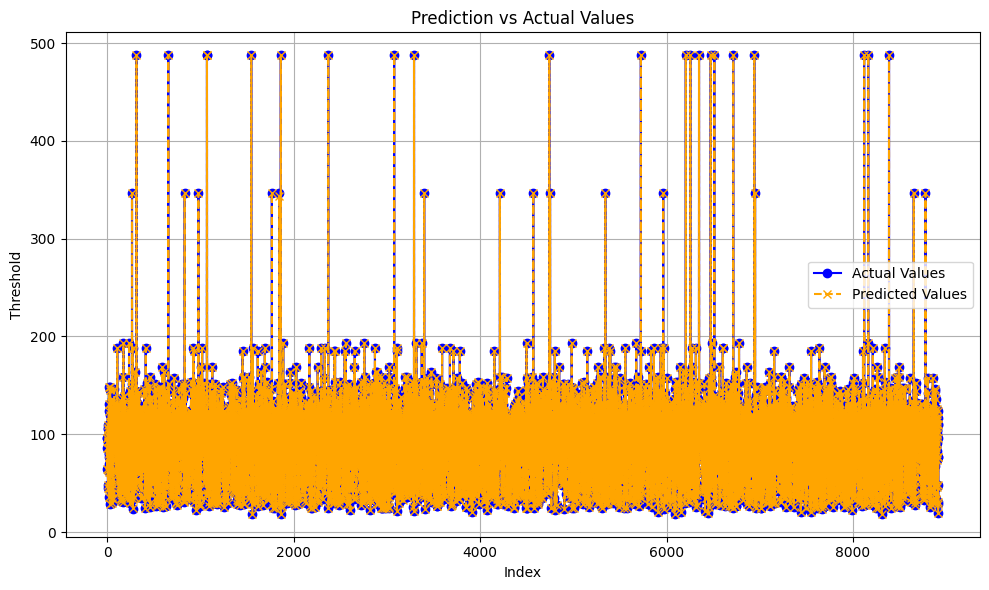

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
# Convert DiseaseDate to datetime and then to timestamp (numeric form)
df2['DiseaseDate'] = pd.to_datetime(df2['DiseaseDate']).astype(int) / 10**9  # convert to seconds

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the 'ICD10_CODE' and 'Anomaly_Flag' columns
df2['ICD10_CODE_encoded'] = label_encoder.fit_transform(df2['ICD10_CODE'])
df2['Anomaly_Flag_encoded'] = label_encoder.fit_transform(df2['Anomaly_Flag'])

# Features (X) and target (y)
features = ['DiseaseDate', 'ICD10_CODE_encoded', 'Anomaly_Flag_encoded', 'Daily_Disease_Count']
X = df2[features]
y = df2['Threshold']

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict the target for the test set
y_pred = rf_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display the results
print("Predicted Threshold values:", y_pred)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

# Ensure y_test is reset as a pandas Series or NumPy array for plotting
y_test = y_test.reset_index(drop=True)

# Plot the Prediction vs Actual values
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', marker='o', linestyle='-', color='blue')
plt.plot(range(len(y_pred)), y_pred, label='Predicted Values', marker='x', linestyle='--', color='orange')

# Adding labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Threshold')
plt.title('Prediction vs Actual Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
import joblib
# Save the model and the encoder

# Save the Random Forest model to a file
joblib.dump(rf_model, 'rf_model.pkl')

# Save the LabelEncoder to a file
joblib.dump(label_encoder, 'label_encoder.pkl')

print("Model and encoder saved successfully!")